In [1]:
import ROOT as rt

Welcome to JupyROOT 6.28/00


In [2]:
load_path = "./fits/calib_fits/Voigtian/workspace_ggh_All_Zfit_no_e_cut_UL_calib_cat12.root"

In [3]:
file = rt.TFile.Open(load_path)

In [4]:
canvas = rt.TCanvas()
canvas.cd()
mass =  rt.RooRealVar("mh_ggh","mass (GeV)",100,85,99)
frame = mass.frame()

In [14]:
bwWidth = rt.RooRealVar("bwz_Width" , "widthZ", 2.5, 0, 30)
bwmZ = rt.RooRealVar("bwz_mZ" , "mZ", 91.2, 90, 92)
sigma = rt.RooRealVar("sigma" , "sigma", 2, 0.0, 5.0)

bwWidth.setConstant(True)
bwmZ.setConstant(True)

model1_1 = rt.RooBreitWigner("bwz", "BWZ",mass, bwmZ, bwWidth)

"""
Note from Jan: sometimes freeze n values in DCB to be frozen (ie 1, but could be other values)
This is because alpha and n are highly correlated, so roofit can be really confused.
Also, given that we care about the resolution, not the actual parameter values alpha and n, we can 
put whatevere restrictions we want.
"""
mean = rt.RooRealVar("mean" , "mean", 0, -5,5) # mean is mean relative to BW
sigma = rt.RooRealVar("sigma" , "sigma", 2, .2, 4.0)
alpha1 = rt.RooRealVar("alpha1" , "alpha1", 2, 0.01, 45)
n1 = rt.RooRealVar("n1" , "n1", 10, 0.01, 185)
alpha2 = rt.RooRealVar("alpha2" , "alpha2", 2.0, 0.01, 65)
n2 = rt.RooRealVar("n2" , "n2", 25, 0.01, 385)
model1_2 = rt.RooCrystalBall("dcb","dcb",mass, mean, sigma, alpha1, n1, alpha2, n2)

model1 = rt.RooFFTConvPdf("BWxDCB", "BWxDCB", mass, model1_1, model1_2)

mass.setBins(10000,"cache") # cache is repre of the varibale only used in FFT
mass.setBins(100) # bin to 100 bins otherwise, fitting with FFT conv is gonna take forever
mass.setMin("cache",50.5) 
mass.setMax("cache",130.5)

c = rt.RooRealVar("c", "c", -1.54, -10, -0.1)
model2 = rt.RooExponential("Exponential", "Exponential", mass,c)


In [10]:
model1.Print()

RooFFTConvPdf::BWxDCB[ bwz(mh_ggh) (*) dcb(mh_ggh) ] = [#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x55cd5230db50 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh] for nset () with code 0
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x55cd532aac60 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 1 from preexisting content.
0.0761858


In [17]:
# minim = rt.RooMinimizer (model1)
# minim.minimize("Minuit2","migrad");  
# model3.fitTo(file.w.data("data_Zfit_no_e_cut_UL_calib_cat20"))
# rooDataset = file.w.data("data_Zfit_no_e_cut_UL_calib_cat12")
# model1.fitTo(rooDataset) # fitting on unbinned data is really slow,
#fitting directly to unbinned dataset is slow, so first make a histogram
roo_dataset = file.w.data("data_Zfit_no_e_cut_UL_calib_cat12")
data_hist = rt.RooDataHist("data_hist","binned version of roo_dataset", rt.RooArgSet(mass), roo_dataset)  # copies binning from mass variable
model1.fitTo(roo_dataset) # fitting on unbinned data is really slow,

<cppyy.gbl.RooFitResult object at 0x(nil)>

[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x55ca751b8be0 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (bwz)
 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha1       2.00000e+00  9.95000e-01    1.00000e-02  4.50000e+01
     2 alpha2       2.00000e+00  9.95000e-01    1.00000e-02  6.50000e+01
     3 mean         0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     4 n1           1.00000

In [16]:
data_hist.Print()

RooDataHist::data_hist[mh_ggh] = 100 bins (355350 weights)


[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x55ca75145aa0 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)


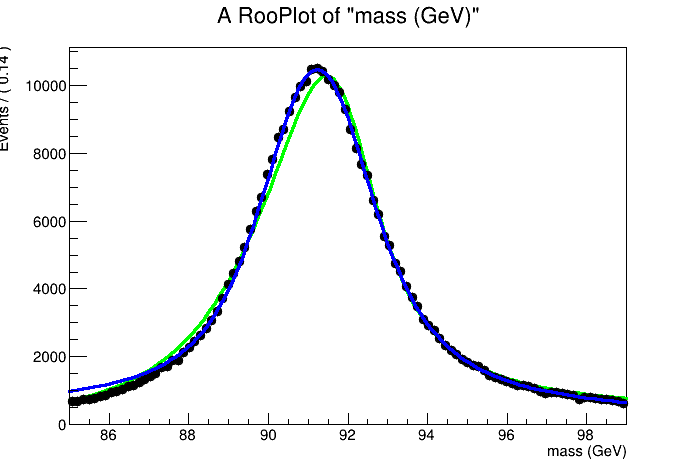

In [19]:

# file.w.pdf("Voigtian_ggh_All").plotOn(frame)
file.w.data("data_Zfit_no_e_cut_UL_calib_cat12").plotOn(frame)
# model3.plotOn(frame, rt.RooFit.LineColor(rt.kGreen))
# model1.plotOn(frame, rt.RooFit.LineColor(rt.kRed))
# model2.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))
# model1_1.plotOn(frame, rt.RooFit.LineColor(rt.kRed))
# model1_2.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))
model1.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))

frame.Draw()
canvas.Update()
canvas.Draw()
